In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
EXTRA_SMALL_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rcParams['lines.linewidth'] = 2.5

In [3]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
MAX_DATE = np.datetime64('2020-09-11')

In [5]:
# https://data.humdata.org/dataset/c87c4508-9caf-4959-bf06-6ab4855d84c6
# See process_positive_rate_world.ipynb
df_test_world = pd.read_csv('../../datasets/test-rate-processed.csv', names=['location', 'date', 'positive_rate'])
df_test_world['date'] = pd.to_datetime(df_test_world['date'])
df_test_world = df_test_world[df_test_world['date'] < MAX_DATE]
df_test_world

,location,date,positive_rate
0,Argentina,2020-02-11,NaN
1,Argentina,2020-02-12,NaN
2,Argentina,2020-02-13,NaN
3,Argentina,2020-02-14,NaN
4,Argentina,2020-02-15,NaN
...,...,...,...
21133,Average,2020-09-06,0.059191
21134,Average,2020-09-07,0.060710
21135,Average,2020-09-08,0.059266
21136,Average,2020-09-09,0.055227


In [6]:
# https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html#a1
# See process_positive_rate_canada.ipynb
df_test_can = pd.read_csv('../../datasets/can_covid19_processed.csv', names=['location', 'date', 'positive_rate'])
df_test_can['date'] = pd.to_datetime(df_test_can['date'])
df_test_can = df_test_can[df_test_can['date'] < MAX_DATE]
df_test_can

,location,date,positive_rate
0,Ontario,2020-01-31,NaN
1,British Columbia,2020-01-31,NaN
2,Ontario,2020-02-08,NaN
3,British Columbia,2020-02-08,NaN
4,Ontario,2020-02-16,NaN
...,...,...,...
2428,Nova Scotia,2020-09-10,0.013124
2429,Prince Edward Island,2020-09-10,0.001803
2430,Yukon,2020-09-10,0.005254
2431,Northwest Territories,2020-09-10,0.001373


In [7]:
df_test = pd.concat([df_test_world, df_test_can])
df_test

,location,date,positive_rate
0,Argentina,2020-02-11,NaN
1,Argentina,2020-02-12,NaN
2,Argentina,2020-02-13,NaN
3,Argentina,2020-02-14,NaN
4,Argentina,2020-02-15,NaN
...,...,...,...
2428,Nova Scotia,2020-09-10,0.013124
2429,Prince Edward Island,2020-09-10,0.001803
2430,Yukon,2020-09-10,0.005254
2431,Northwest Territories,2020-09-10,0.001373


In [8]:
blacklist = ['Taiwan*', 'Nunavut', 'Luxembourg']
nodes = np.array(list(set(df_test['location'].unique()).difference(set(blacklist))))
dates = pd.to_datetime(sorted(df_test['date'].unique()))

In [9]:
def plot_interpolated_positive_rate(ax, idx, x, y, pred_x, pred_y, node):
    ax =  ax[int(idx/6), idx % 6]
    ax.plot(x, y, 'o')
    ax.plot(pred_x, pred_y, '-')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.set_title(node)
    ax.get_xaxis().set_visible(False)

In [10]:
def get_rates():
    xs = []
    ys = []
    rates = np.zeros(shape=(nodes.shape[0], len(dates)))
    col, row = 6,  math.ceil(rates.shape[0]/6) 
    fig, ax = plt.subplots(row, col, figsize=(col* 6, row * 4))
    for n_idx, node in enumerate(nodes): 
        df_node = df_test[df_test['location'] == node]
        y_nan = np.isnan(df_node['positive_rate']) 
        x = df_node['date'][~y_nan].dt.dayofyear.to_list()
        y = df_node['positive_rate'][~y_nan].to_list()
        if x[0] > 0:
#             print("Data points less than expected (lower):", node)
            x0 = np.linspace(0, x[0] , num=int(x[0]/20), endpoint=False)
            x = np.append(x0, x)
            y0 = np.zeros(len(x0))
            y = np.append(y0, y)
        if x[-1] < dates[-1].dayofyear:
#             print("Data points less than expected (higher):", node)
            x = np.append(x, dates[-1].dayofyear)
            y = np.append(y, y[y > 0.0][-1])
        f = interp1d(x, y, kind='slinear')
        rates[n_idx] = [max(r, 0.0) for r in f(dates.dayofyear)]
        xs.append(x)
        ys.append(y)
        plot_interpolated_positive_rate(ax, n_idx, x, y, dates.dayofyear, rates[n_idx], node)
    return np.transpose(rates), xs, ys

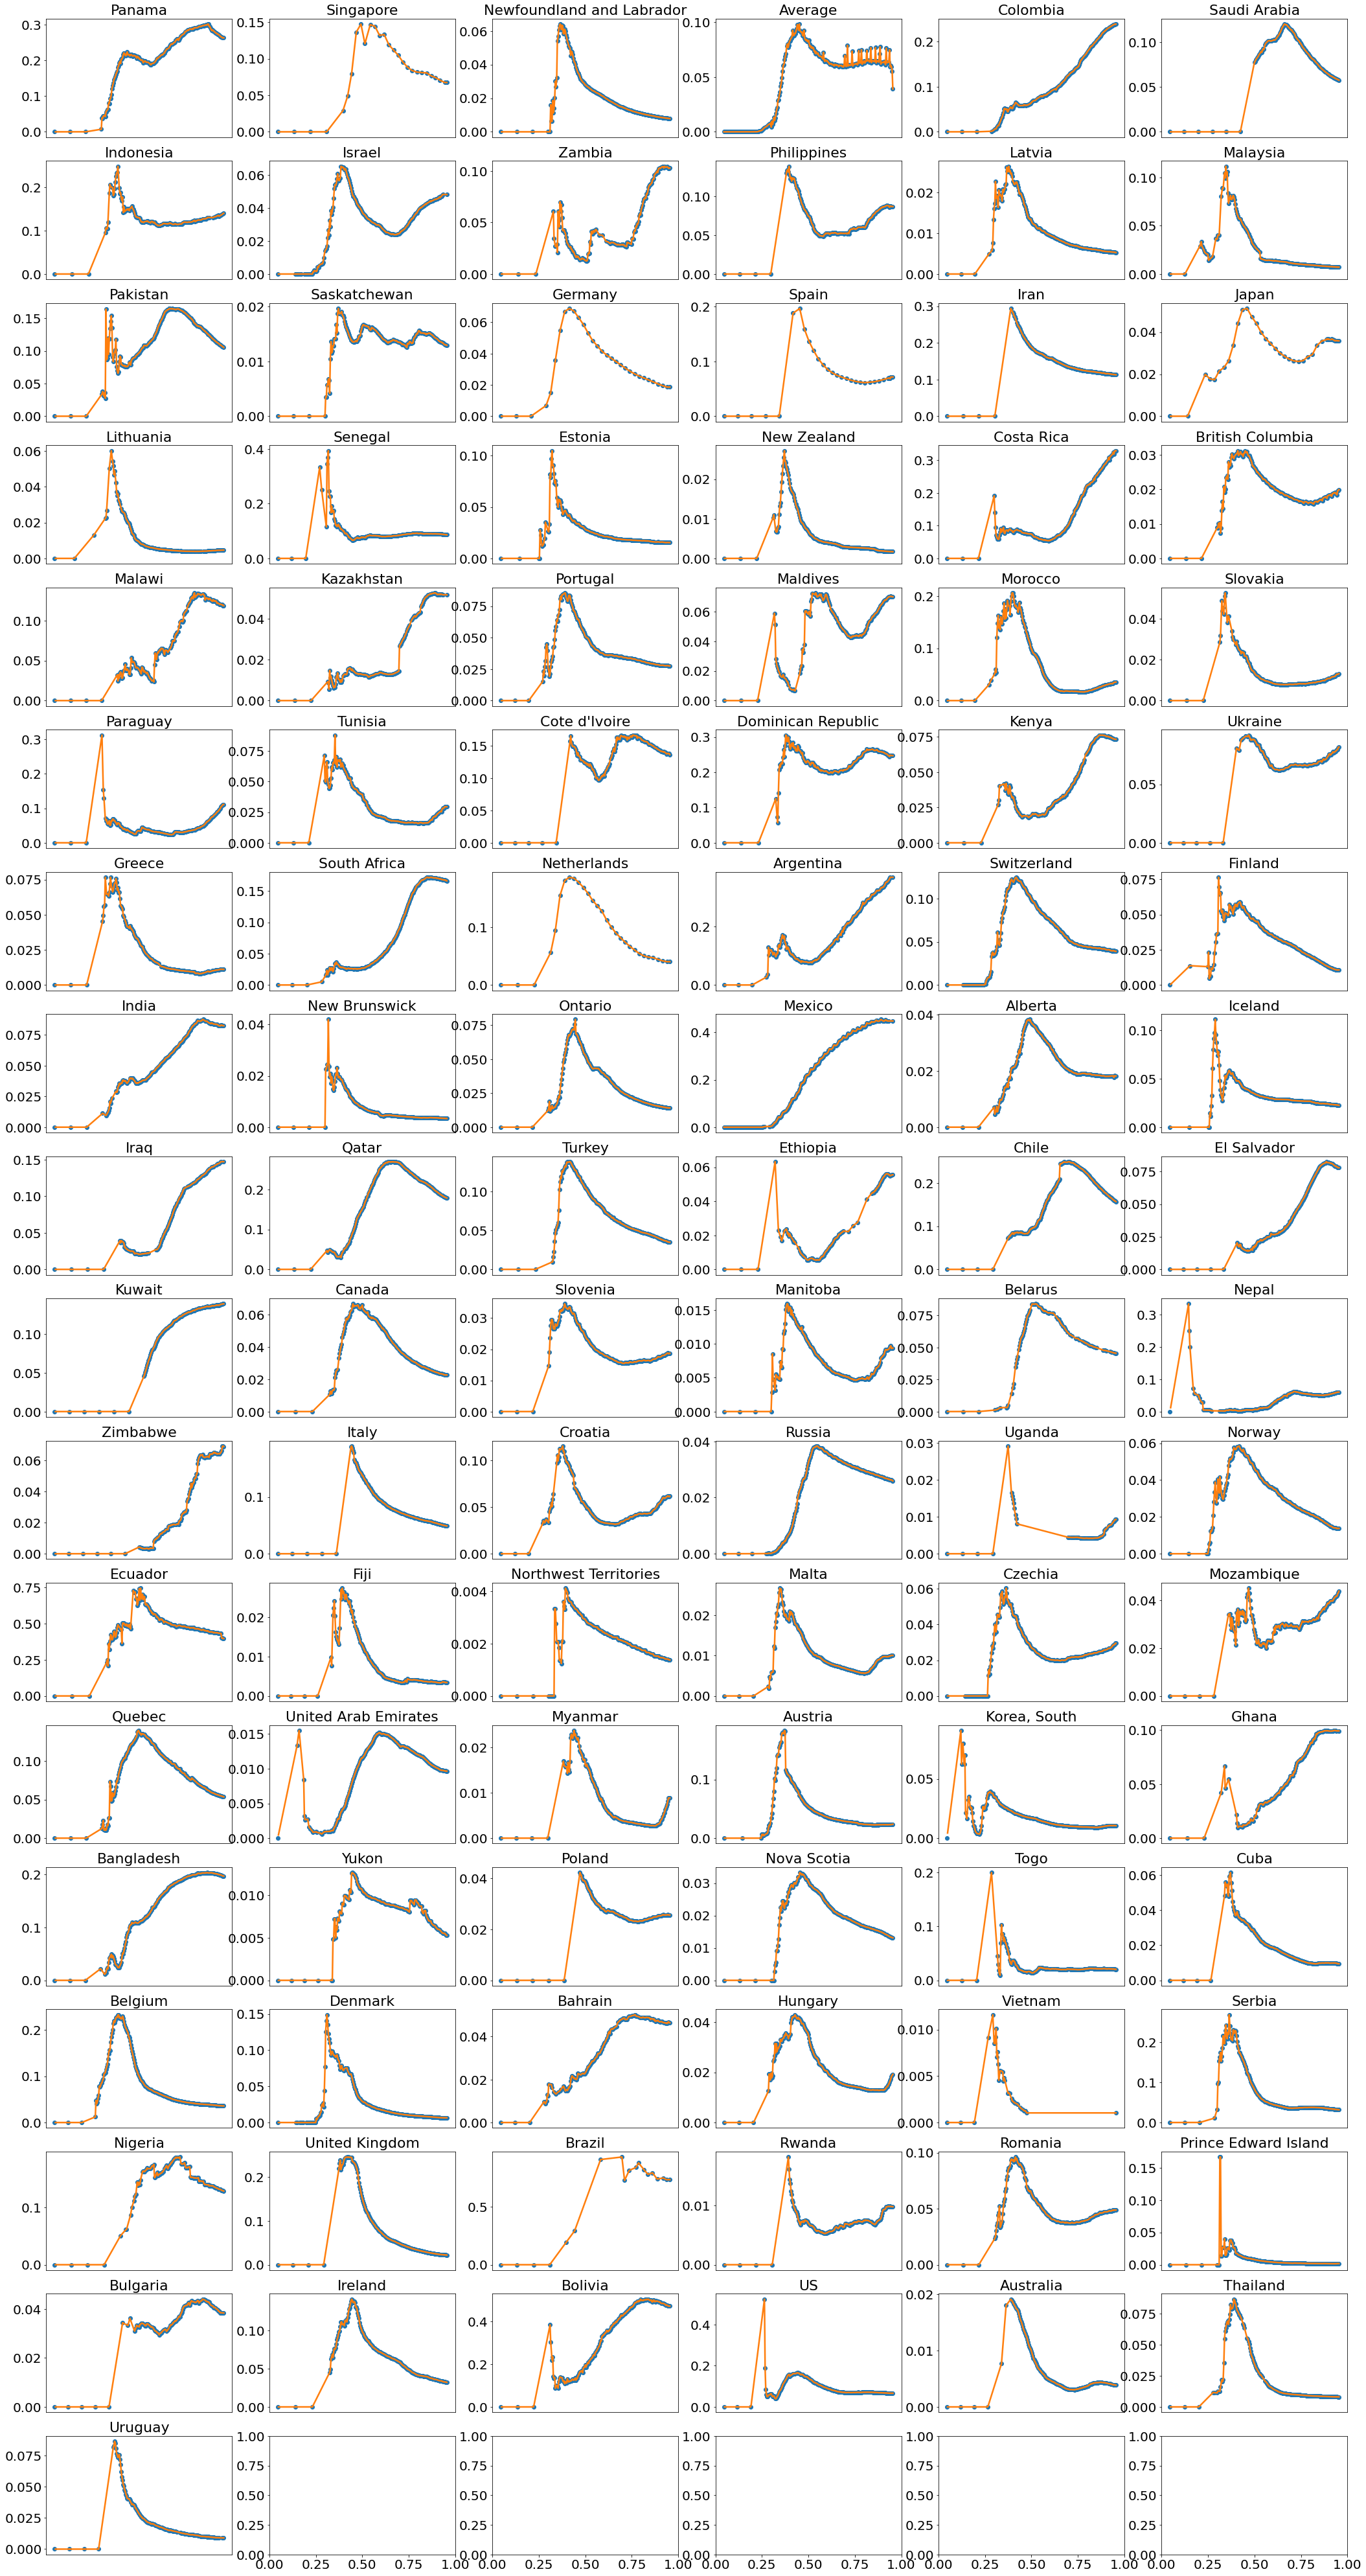

In [11]:
rates, xs, ys = get_rates()

In [12]:
print(rates.shape)
print(len(xs))
print(len(ys))

(254, 103)
103
103


In [13]:
df_rates = pd.DataFrame(rates, index=dates, columns=nodes)

In [14]:
df_rates

,Panama,Singapore,Newfoundland and Labrador,Average,Colombia,Saudi Arabia,Indonesia,Israel,Zambia,Philippines,...,Rwanda,Romania,Prince Edward Island,Bulgaria,Ireland,Bolivia,US,Australia,Thailand,Uruguay
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-06,0.265609,0.067939,0.008102,0.059191,0.237184,0.059179,0.136042,0.048152,0.103973,0.087327,...,0.009886,0.048421,0.001596,0.038431,0.032807,0.477278,0.066545,0.003937,0.008112,0.009026
2020-09-07,0.265238,0.067511,0.008053,0.060710,0.238213,0.058864,0.136919,0.048152,0.103579,0.087348,...,0.009844,0.048832,0.001725,0.038424,0.032733,0.474557,0.066576,0.003926,0.008103,0.009000
2020-09-08,0.262979,0.067511,0.008020,0.059266,0.238288,0.058482,0.138192,0.048152,0.102631,0.086815,...,0.009850,0.048771,0.001781,0.038418,0.032605,0.472753,0.066510,0.003911,0.008078,0.008975
2020-09-09,0.262979,0.067511,0.007966,0.055227,0.238970,0.058080,0.139466,0.048152,0.102681,0.086880,...,0.009834,0.048746,0.001829,0.038350,0.032557,0.472753,0.066510,0.003885,0.008054,0.008975


In [15]:
def plot_rates(target_countries, df, label, filename):
    fig = plt.figure(facecolor='w', figsize=(16, 8))
    ax = fig.add_subplot(111)
    for c in target_countries:
        rate = df[c].to_list()
        date = df[c].index
        node_idx = np.argwhere(nodes == c)[0][0]
        x = [df[c].index[int(i - 1)] for i in xs[node_idx]]
        ax.scatter(x, ys[node_idx])
        ax.plot(date, rate, '--', label=c)
    ax.set_xlabel('Date')
    ax.set_ylabel('Positive Rate')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 14))
    ax.xaxis.set_tick_params(rotation=30)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.savefig(filename, bbox_inches='tight')

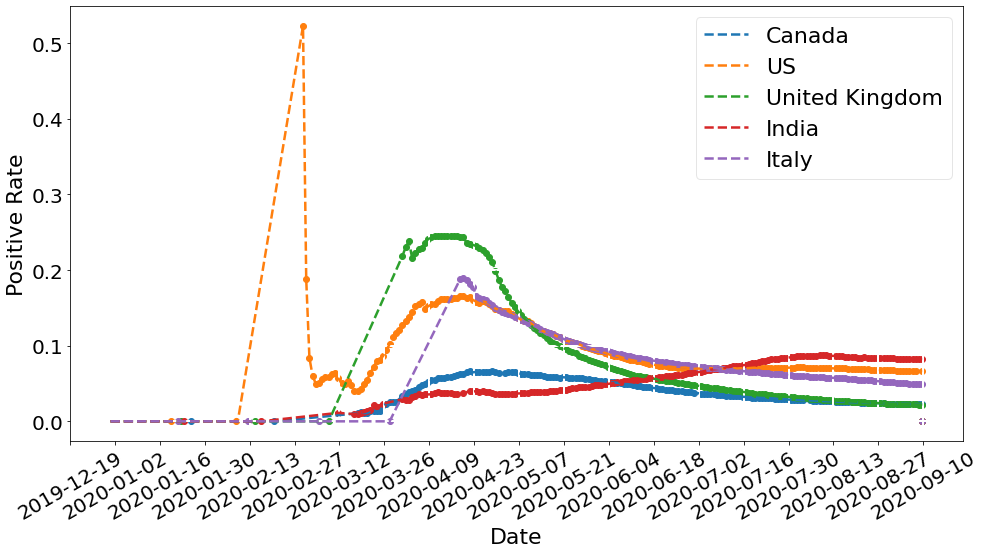

In [16]:
target_countries = ['Canada', 'US', 'United Kingdom', 'India', 'Italy']
plot_rates(target_countries, df_rates, "positive_rate", '../../graphs/flights/positive_rates_countries.png')

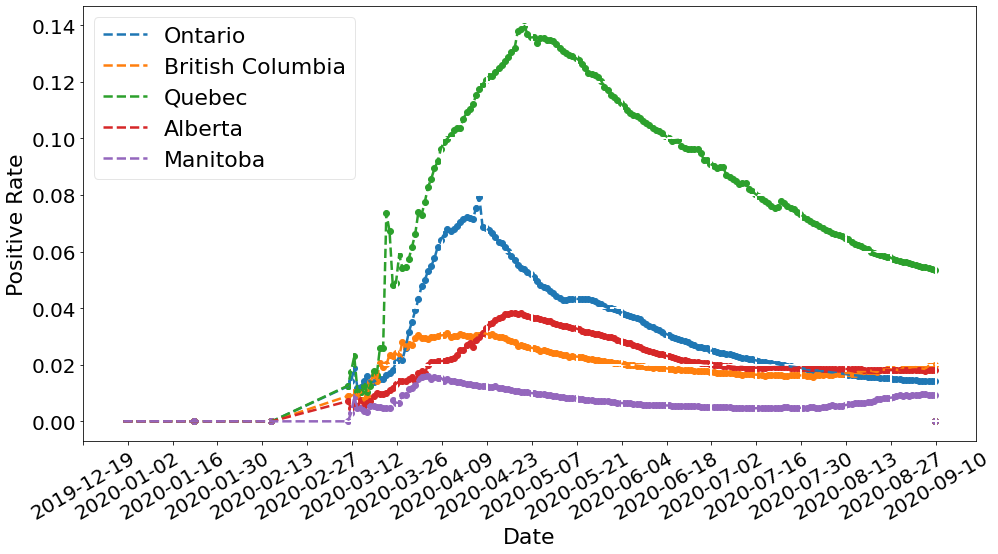

In [17]:
target_provinces = ['Ontario', 'British Columbia', 'Quebec', 'Alberta', 'Manitoba']
plot_rates(target_provinces, df_rates, "positive_rate", '../../graphs/flights/positive_rates_provinces.png')

In [18]:
df_rates.to_csv('../../datasets/interpolated_positive_rates.csv', index=True, header=True)

In [19]:
# pd.read_csv('../dataset/stable/interpolated_positive_rates.csv', index_col=0)